In [5]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
#1) Utworzyć ramkę danych, która dla każdego leku zawiera następujące informacje: unikalny
#identyfikator leku w bazie DrugBank, nazwę leku, jego typ, opis, postać w jakiej dany lek
#występuje, wskazania, mechanizm działania oraz informacje z jakimi pokarmami dany lek
#wchodzi w interakcje. (4 pkt)

tree = ET.parse('data/drugbank_partial.xml')
root = tree.getroot()

ns = {'db': 'http://www.drugbank.ca'}

data = {
    "DrugBank ID": [],
    "Name": [],
    "Type": [],
    "Description": [],
    "State": [],
    "Indication": [],
    "Mechanism of Action": [],
    "Food Interactions": [],
}

for drug in root.findall("db:drug", ns):
    data["DrugBank ID"].append(drug.find("db:drugbank-id", ns).text)
    data["Name"].append(drug.find("db:name", ns).text)
    data["Type"].append(drug.get("type"))
    data["Description"].append(drug.find("db:description", ns).text if drug.find("db:description", ns) is not None else None)
    data["State"].append(drug.find("db:state", ns).text)
    data["Indication"].append(drug.find("db:indication", ns).text if drug.find("db:indication", ns) is not None else None)
    data["Mechanism of Action"].append(
        drug.find("db:mechanism-of-action", ns).text if drug.find("db:mechanism-of-action", ns) is not None else None
    )
    data["Food Interactions"].append(
        ";".join(food_interaction.text for food_interaction in drug.findall("db:food-interactions/db:food-interaction", ns))
    )

df = pd.DataFrame(data)
display(df.head())

,DrugBank ID,Name,Type,Description,State,Indication,Mechanism of Action,Food Interactions
0,DB00001,Lepirudin,biotech,Lepirudin is a recombinant hirudin formed by 6...,solid,Lepirudin is indicated for anticoagulation in ...,Lepirudin is a direct thrombin inhibitor used ...,Avoid herbs and supplements with anticoagulant...
1,DB00002,Cetuximab,biotech,Cetuximab is a recombinant chimeric human/mous...,liquid,Cetuximab indicated for the treatment of local...,The epidermal growth factor receptor (EGFR) is...,
2,DB00003,Dornase alfa,biotech,Dornase alfa is a biosynthetic form of human d...,liquid,Used as adjunct therapy in the treatment of cy...,Dornase alfa is a biosynthetic form of human D...,
3,DB00004,Denileukin diftitox,biotech,A recombinant DNA-derived cytotoxic protein co...,liquid,For treatment of cutaneous T-cell lymphoma,Denileukin diftitox binds to the high-affinity...,
4,DB00005,Etanercept,biotech,Dimeric fusion protein consisting of the extra...,liquid,Etanercept is indicated for the treatment of m...,There are two distinct receptors for TNF (TNFR...,


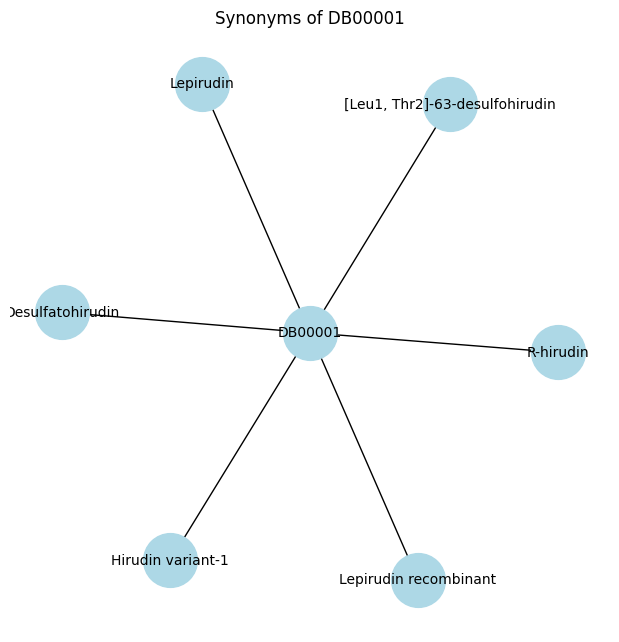

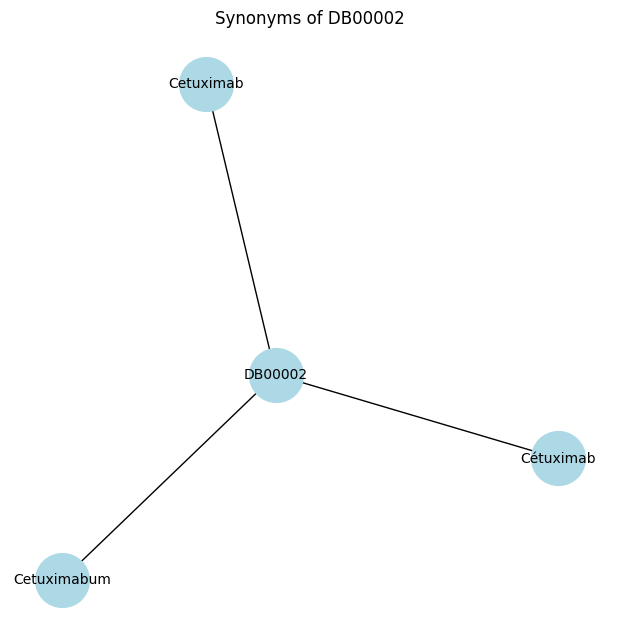

In [7]:
#2) Utworzyć ramkę danych pozwalającą na wyszukiwanie po DrugBank ID informacji o
#wszystkich synonimach pod jakimi dany lek występuje. Napisać funkcję, która dla podanego
#DrugBank ID utworzy i wyrysuje graf synonimów za pomocą biblioteki NetworkX. Należy
#zadbać o czytelność generowanego rysunku. (4 pkt)

def graph_of_synonyms(DBID : str):
    synonyms = []

    for drug in root.findall("db:drug", ns):
        if drug.find("db:drugbank-id", ns).text != DBID:
            continue
        for synonym in drug.findall("db:synonyms/db:synonym", ns):
            synonyms.append(synonym.text)

    G = nx.Graph()
    G.add_node(DBID, label=DBID)

    for s in synonyms:
        G.add_node(s, label=s)
        G.add_edge(DBID, s)
    
    spring_layout = nx.spring_layout(G)

    plt.figure(figsize=(6, 6))
    nx.draw(G, spring_layout, with_labels=True, node_size=1500, node_color='lightblue', font_size=10)
    plt.title(f"Synonyms of {DBID}")
    plt.show()

graph_of_synonyms("DB00001")
graph_of_synonyms("DB00002")

In [8]:
#3) Utworzyć ramkę danych o produktach farmaceutycznych zawierających dany lek
#(substancję leczniczą). Ramka powinna zawierać informacje o ID leku, nazwie produktu,
#producencie, kod w narodowym rejestrze USA (ang. *National Drug Code*), postać w jakiej
#produkt występuje, sposób aplikacji, informacje o dawce, kraju i agencji rejestrującej
#produkt. (4 pkt)

data = {
    "DrugBank ID": [],
    "Product name": [],
    "Labeller": [],
    "NDC": [],
    "Form": [],
    "Strength": [],
    "Route": [],
    "Country": [],
    "Source": [],
}

for drug in root.findall("db:drug", ns):
    for product in drug.findall("db:products/db:product", ns):
        data["DrugBank ID"].append(drug.find("db:drugbank-id", ns).text)
        data["Product name"].append(product.find("db:name", ns).text)
        data["Labeller"].append(product.find("db:labeller", ns).text)
        data["NDC"].append(product.find("db:ndc-product-code", ns).text)
        data["Form"].append(product.find("db:dosage-form", ns).text)
        data["Strength"].append(product.find("db:strength", ns).text)
        data["Route"].append(product.find("db:route", ns).text)
        data["Country"].append(product.find("db:country", ns).text)
        data["Source"].append(product.find("db:source", ns).text)

df = pd.DataFrame(data)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
display(df.head())

,DrugBank ID,Product name,Labeller,NDC,Form,Strength,Route,Country,Source
0,DB00001,Refludan,Bayer,50419-150,Powder,50 mg/1mL,Intravenous,US,FDA NDC
1,DB00001,Refludan,Bayer,None,"Powder, for solution",50 mg / vial,Intravenous,Canada,DPD
2,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",50 mg,Intravenous,EU,EMA
3,DB00001,Refludan,Celgene Europe Limited,None,"Injection, solution, concentrate",20 mg,Intravenous,EU,EMA
4,DB00002,Erbitux,ImClone LLC,66733-948,Solution,2 mg/1mL,Intravenous,US,FDA NDC


In [9]:
#4) Utworzyć ramkę danych zawierającą informacje o wszystkich szlakach wszystkich
#rodzajów, tj. sygnałowych, metabolicznych, itd., z jakimi jakikolwiek lek wchodzi w interakcje.
#Podać całkowitą liczbę tych szlaków. (4 pkt)

#data = {
#    "smpdb id": [],
#    "name": [],
#    "category": [],
#}
#
#for drug in root.findall("db:drug", ns):
#    for pathway in drug.findall("db:pathways/db:pathway", ns):
#        data["smpdb id"].append(pathway.find("db:smpdb-id", ns).text)
#        data["name"].append(pathway.find("db:name", ns).text)
#        data["category"].append(pathway.find("db:category", ns).text)
#
#pathways = pd.DataFrame(data)
#display(pathways)
#print(f"Total number of pathways: {len(pathways)}")

data = {
    "pathway_name": [],
    "drug": [],
}

for drug in root.findall("db:drug", ns):
    for target in drug.findall("db:targets/db:target", ns):
        for go_c in target.findall("db:polypeptide/db:go-classifiers/db:go-classifier", ns):
            desc = go_c.find("db:description", ns).text
            if desc.endswith("pathway"):
                data["pathway_name"].append(desc)
                data["drug"].append(drug.find("db:drugbank-id", ns).text)

pathways = pd.DataFrame(data)
#display(pathways)
unique_pathways_count = pathways["pathway_name"].nunique()
print(f"Total number of pathways: {unique_pathways_count}")

Total number of pathways: 95


,interleukin-1-mediated signaling pathway,positive regulation of vascular endothelial growth factor receptor signaling pathway,integrin-mediated signaling pathway,glucocorticoid receptor signaling pathway,thyroid-stimulating hormone signaling pathway,toll-like receptor 3 signaling pathway,extrinsic apoptotic signaling pathway,positive regulation of platelet-derived growth factor receptor signaling pathway,follicle-stimulating hormone signaling pathway,toll-like receptor 4 signaling pathway,...,interleukin-7-mediated signaling pathway,necroptotic signaling pathway,type I interferon signaling pathway,interleukin-4-mediated signaling pathway,"negative regulation of blood coagulation, common pathway",negative regulation of smoothened signaling pathway,urokinase plasminogen activator signaling pathway,neurotrophin TRK receptor signaling pathway,luteinizing hormone signaling pathway,JAK-STAT cascade involved in growth hormone signaling pathway
DB00045,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
DB00087,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00043,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00011,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
DB00018,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


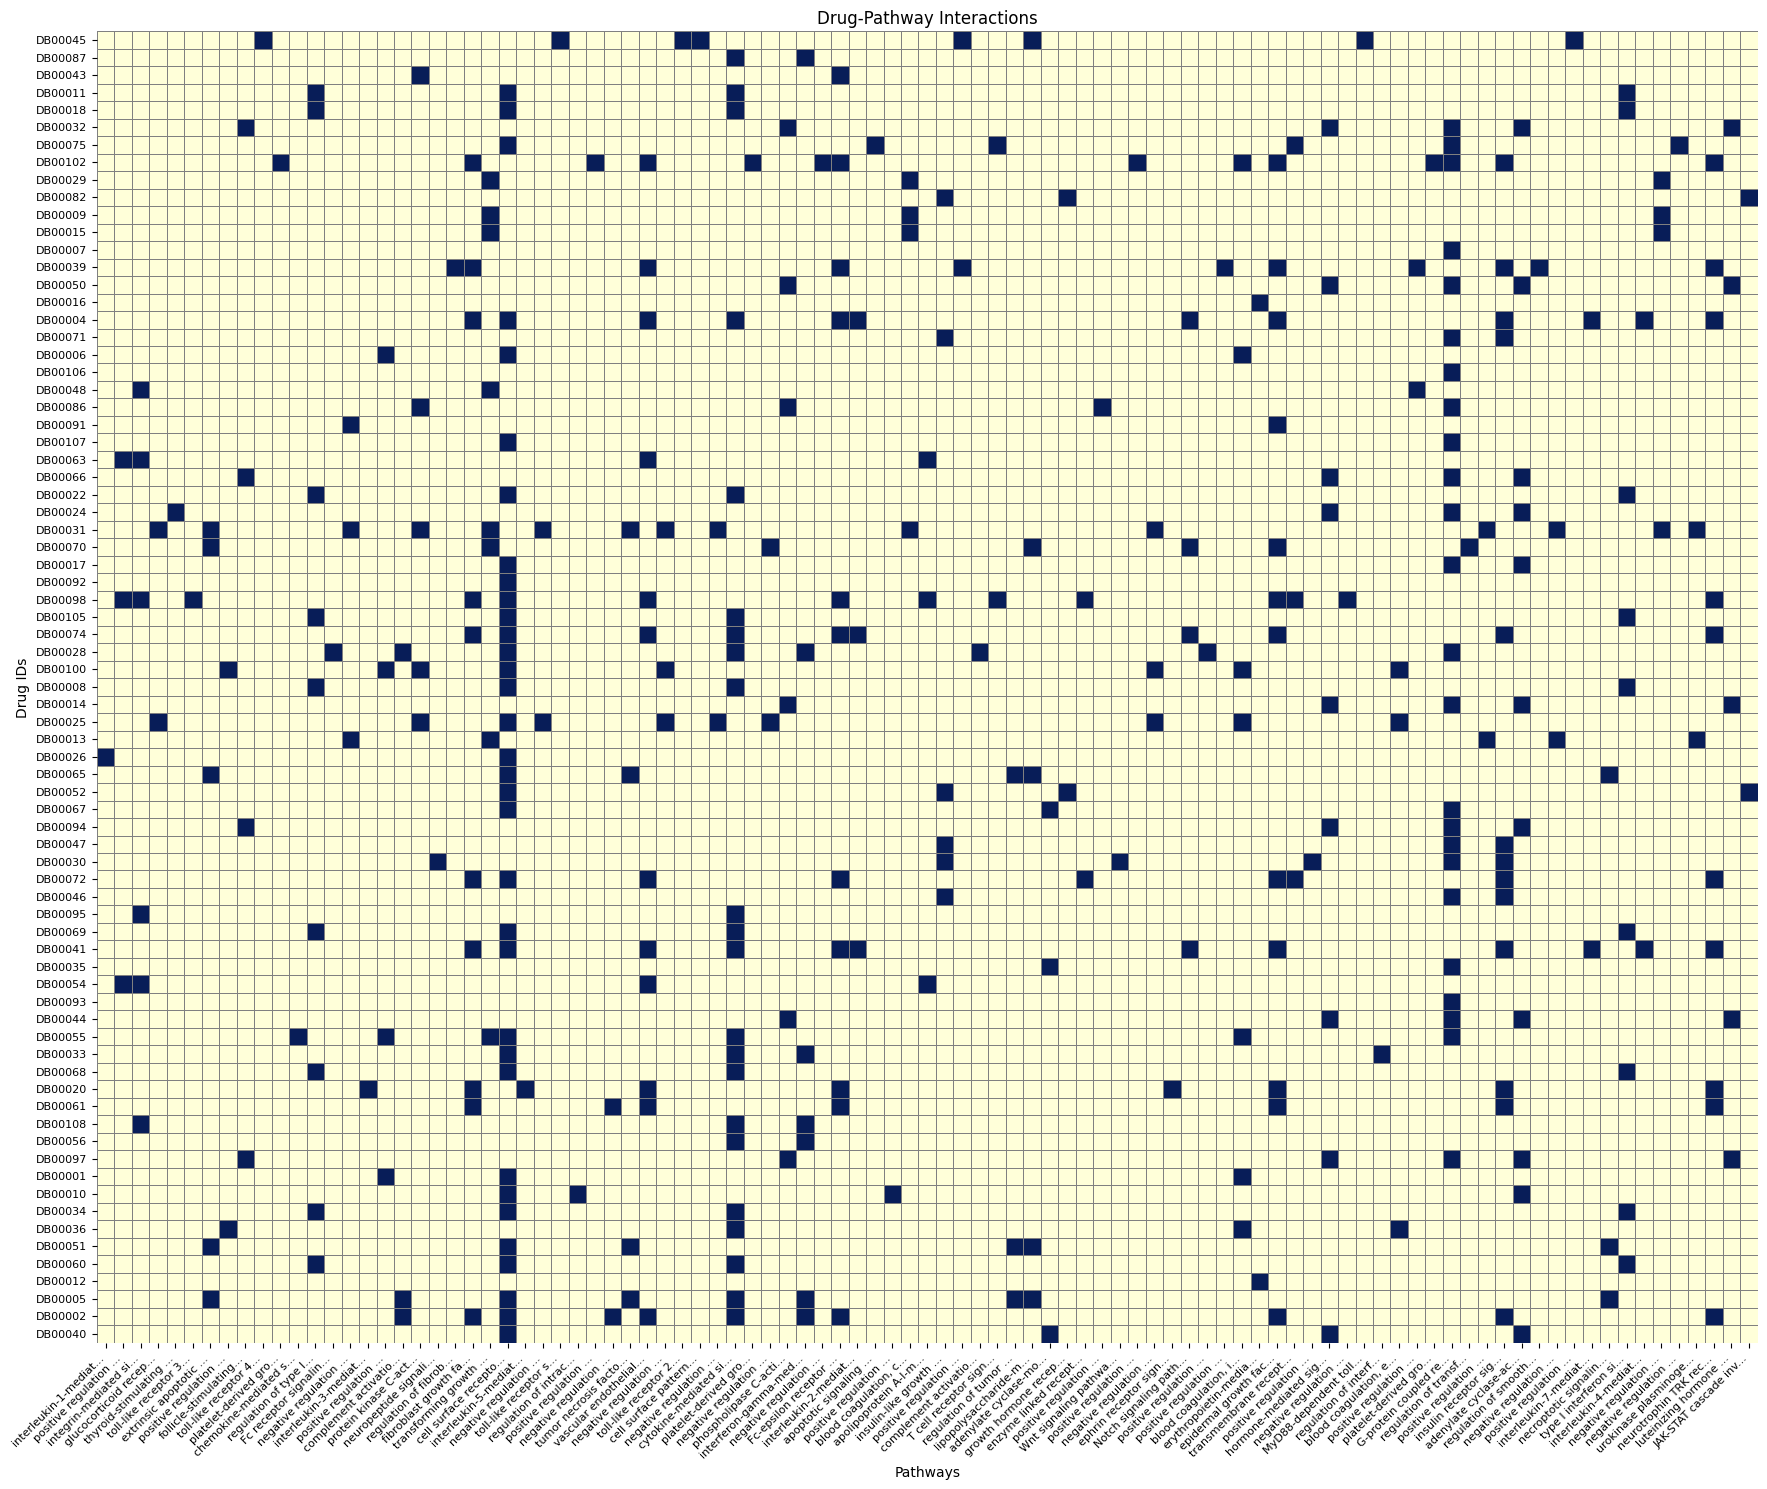

In [10]:
#5) Dla każdego szlaku sygnałowego/metabolicznego w bazie danych podać leki, które
#wchodzą z nim w interakcje. Wyniki należy przedstawić w postaci ramki danych jak i w
#opracowanej przez siebie formie graficznej. Przykładem takiej grafiki może być graf
#dwudzielny, gdzie dwa rodzaje wierzchołków to szlaki sygnałowe i leki, a poszczególne
#krawędzie reprezentują interakcję danego leku z danym szlakiem sygnałowym. Należy
#zadbać o czytelność i atrakcyjność prezentacji graficznej. (4 pkt)

pathways_set = set(pathways["pathway_name"])
drugs_set = set(pathways["drug"]) # TODO add the drugs that have no pathways

drug_pathway_df = pd.DataFrame(0, index=list(drugs_set), columns=list(pathways_set))
for index, row in pathways.iterrows():
    drug_pathway_df.at[row['drug'], row['pathway_name']] = 1
display(drug_pathway_df.head())



max_label_length = 20
short_labels = {col: (col if len(col) <= max_label_length else col[:max_label_length] + '...')
                for col in drug_pathway_df.columns}
drug_pathway_df = drug_pathway_df.rename(columns=short_labels)

plt.figure(figsize=(20, 15))
ax = sns.heatmap(drug_pathway_df,
                 cmap="YlGnBu",
                 cbar=False,
                 linewidths=0.5,
                 linecolor='gray',
                 square=True)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=8)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.xlabel("Pathways")
plt.ylabel("Drug IDs")
plt.title("Drug-Pathway Interactions")

plt.tight_layout()
plt.show()

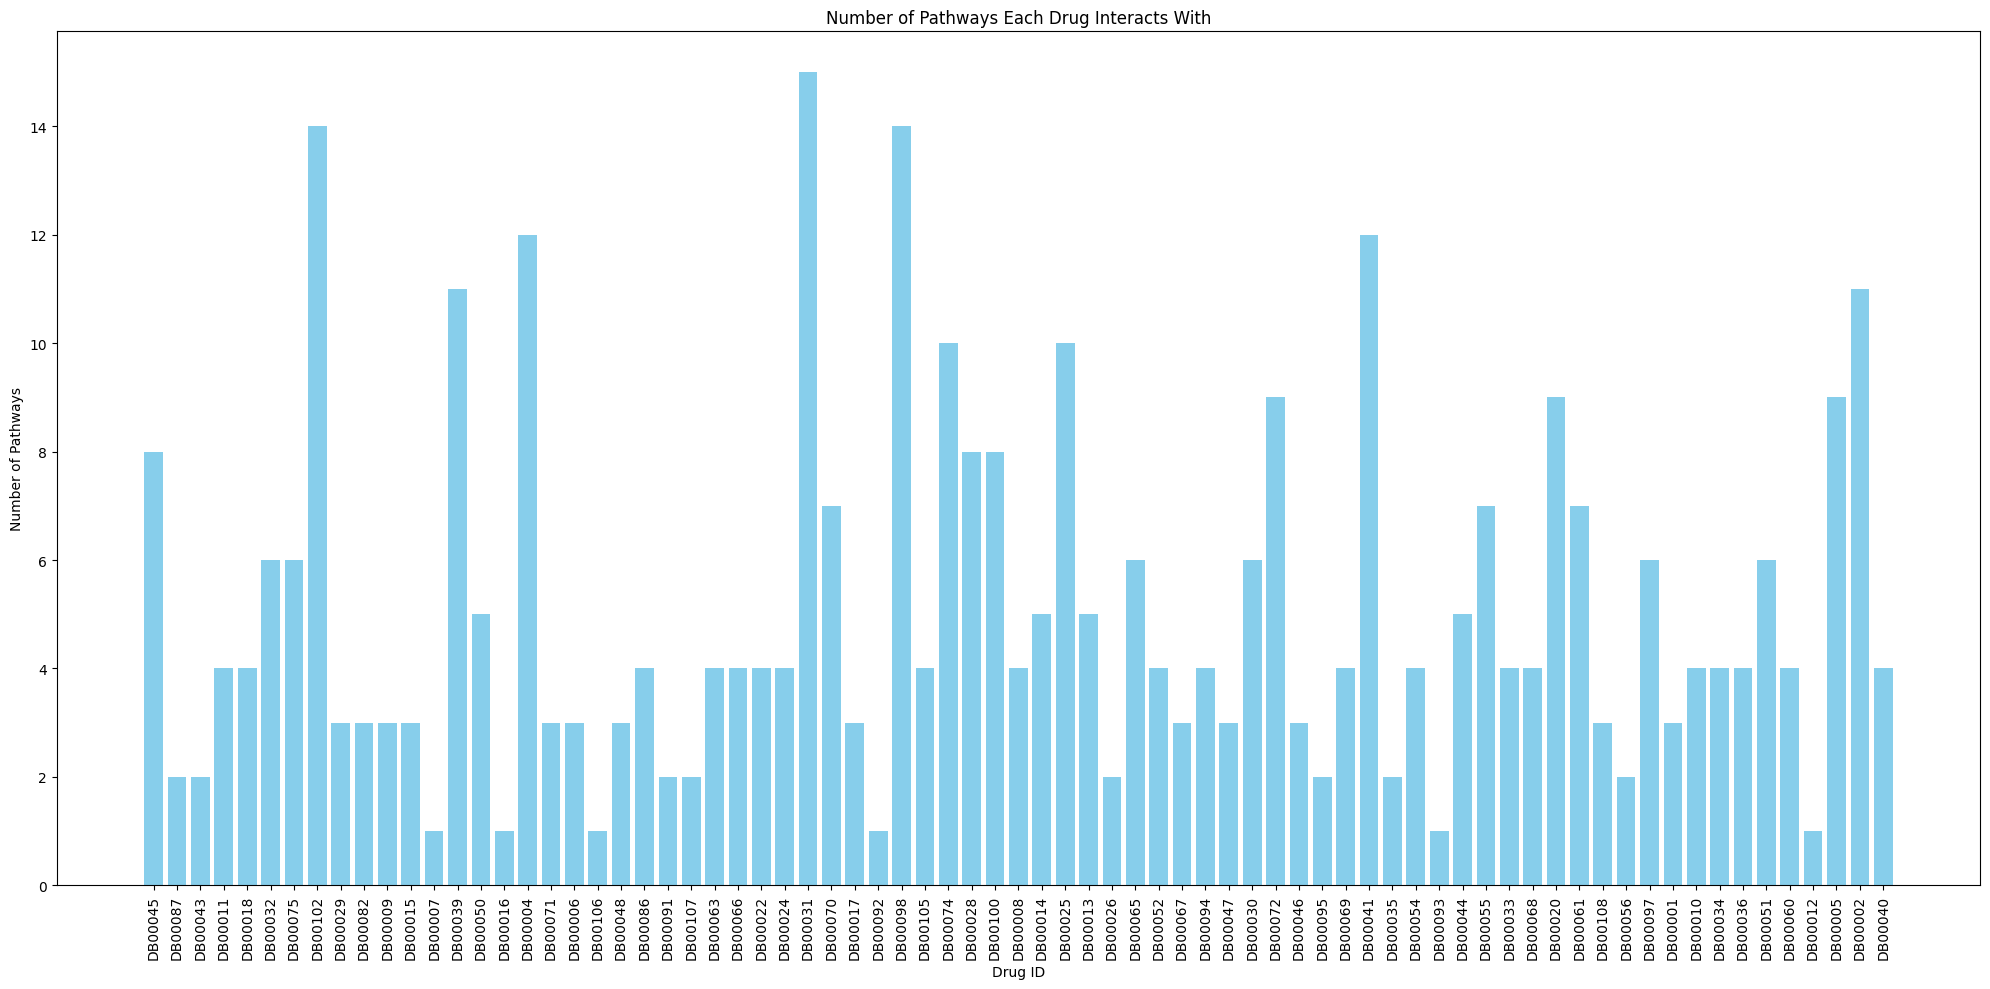

In [11]:
#6) Dla każdego leku w bazie danych podać liczbę szlaków, z którymi dany lek wchodzi w
#interakcje. Przedstawić wyniki w postaci histogramu z odpowiednio opisanymi osiami.

interaction_counts = drug_pathway_df.sum(axis=1)

plt.figure(figsize=(20, 10))
plt.bar(interaction_counts.index, interaction_counts.values, color='skyblue')

plt.xlabel("Drug ID")
plt.ylabel("Number of Pathways")
plt.title("Number of Pathways Each Drug Interacts With")

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
#7) Utworzyć ramkę danych zawierającą informacje o białkach, z którymi poszczególne leki
#wchodzą w interakcje. Białka te to tzw. targety. Ramka danych powinna zawierać
#przynajmniej DrugBank ID targetu, informację o zewnętrznej bazie danych (ang. *source*,
#np. Swiss-Prot), identyfikator w zewnętrznej bazie danych, nazwę polipeptydu, nazwę genu
#kodującego polipeptyd, identyfikator genu GenAtlas ID, numer chromosomu, umiejscowienie
#w komórce. (4 pkt)

data = {
    "DrugBank ID": [],
    "Source": [],
    "External ID": [],
    "Name": [],
    "Gene Name": [],
    "GenAtlas ID": [],
    "Chromosome": [],
    "Cell Location": [],
}

for drug in root.findall("db:drug", ns):
    for target in drug.findall("db:targets/db:target", ns):
        polypeptide = target.find("db:polypeptide", ns)
        if polypeptide is None:
            continue

        data["DrugBank ID"].append(target.find("db:id", ns).text)
        data["Source"].append(polypeptide.get("source"))
        data["External ID"].append(polypeptide.get("id"))
        data["Name"].append(polypeptide.find("db:name", ns).text)
        data["Gene Name"].append(polypeptide.find("db:gene-name", ns).text)
        data["Chromosome"].append(polypeptide.find("db:chromosome-location", ns).text)
        data["Cell Location"].append(polypeptide.find("db:cellular-location", ns).text)
        
        for ext_id in polypeptide.findall("db:external-identifiers/db:external-identifier", ns):
            if ext_id.find("db:resource", ns).text == "GenAtlas":
                data["GenAtlas ID"].append(ext_id.find("db:identifier", ns).text)
                break
        if (len(data["GenAtlas ID"]) < len(data["DrugBank ID"])):
            data["GenAtlas ID"].append(None)

df = pd.DataFrame(data)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
display(df.sample(10))

,DrugBank ID,Source,External ID,Name,Gene Name,GenAtlas ID,Chromosome,Cell Location
112,BE0003456,Swiss-Prot,P04234,T-cell surface glycoprotein CD3 delta chain,CD3D,CD3D,11,Membrane
82,BE0000857,Swiss-Prot,P43220,Glucagon-like peptide 1 receptor,GLP1R,GLP1R,6,Cell membrane
139,BE0001085,Swiss-Prot,P05362,Intercellular adhesion molecule 1,ICAM1,ICAM1,19,Membrane
61,BE0001147,Swiss-Prot,P48745,Protein NOV homolog,NOV,NOV,8,Secreted
123,BE0001014,Swiss-Prot,P62937,Peptidyl-prolyl cis-trans isomerase A,PPIA,PPIA,7,Cytoplasm
135,BE0000205,Swiss-Prot,P09619,Platelet-derived growth factor receptor beta,PDGFRB,PDGFRB,5,Cell membrane
118,BE0000928,Swiss-Prot,P25116,Proteinase-activated receptor 1,F2R,F2R,5,Cell membrane
64,BE0002105,Swiss-Prot,P05787,"Keratin, type II cytoskeletal 8",KRT8,KRT8,None,Cytoplasm
44,BE0002117,Swiss-Prot,O14832,"Phytanoyl-CoA dioxygenase, peroxisomal",PHYH,PHYH,10,Peroxisome
95,BE0000439,Swiss-Prot,P08514,Integrin alpha-IIb,ITGA2B,ITGA2B,17,Membrane


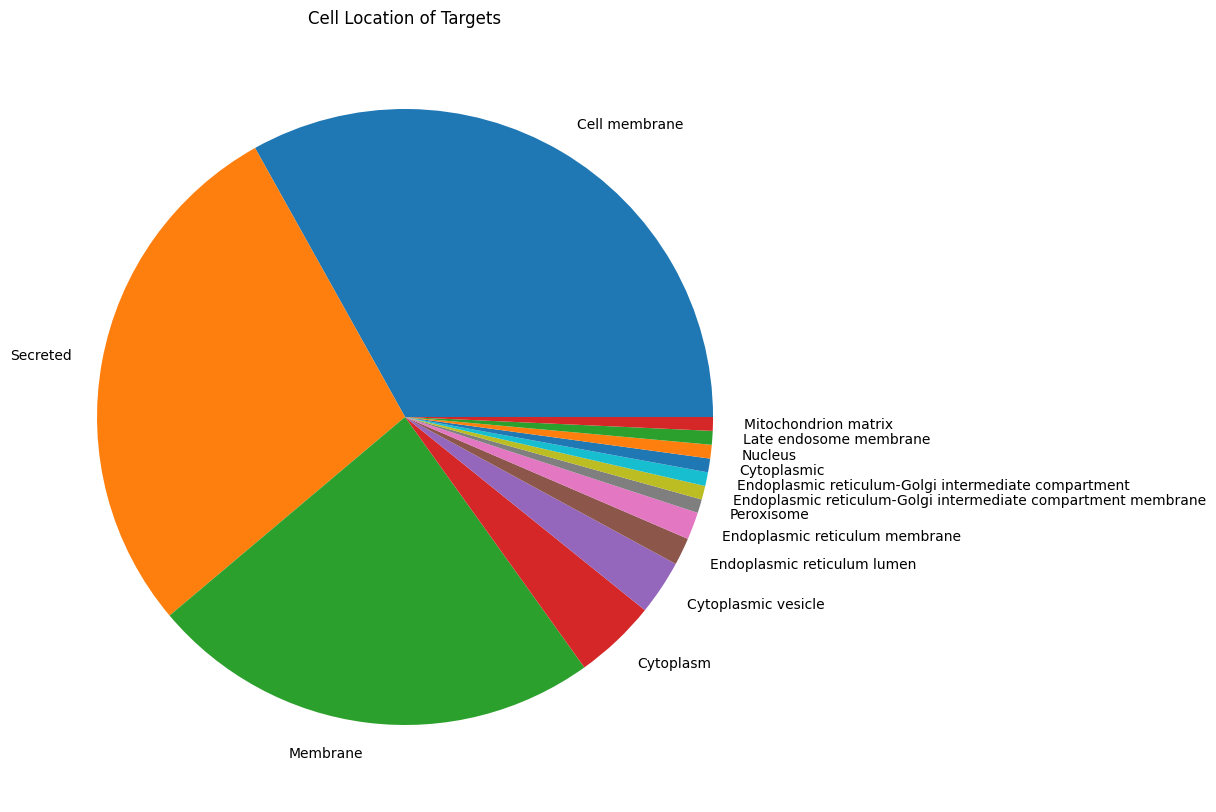

In [22]:
#8) Utworzyć wykres kołowy prezentujący procentowe występowanie targetów w różnych
#częściach komórki. (4 pkt)

cell_location_counts = df["Cell Location"].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(cell_location_counts, labels=cell_location_counts.index)
plt.title("Cell Location of Targets")
plt.show()
